# Summary

Model-derived values predict animals' choices. In the manuscript: **Fig. 1J-M**.

---
# Setup


In [8]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import label_binarize

from popy.io_tools import load_behavior
from popy.behavior_data_tools import add_foraging_value, add_RL_values
from popy.config import COLORS

# mute warnings (due to low amount of data in demo dataset)
import warnings
warnings.filterwarnings("ignore")


In [9]:
# local functions
def get_proportions(X, y, x_bins):
    bin_edges = x_bins
    
    proportions = []
    bin_counts = []

    for k in range(len(bin_edges) - 1):
        mask = (X >= bin_edges[k]) & (X < bin_edges[k+1])
        if k == len(bin_edges) - 2:  # Include the last edge
            mask = (X >= bin_edges[k]) & (X <= bin_edges[k+1])

        if np.sum(mask) > 0:  # Avoid division by zero
            prop_correct = np.mean(y[mask])
            proportions.append(prop_correct)
            bin_counts.append(np.sum(mask))
        else:
            proportions.append(np.nan)
            bin_counts.append(0)

    return np.array(proportions)

def plot_probab_of_stay(probab_of_stay_full, bin_centers, ax=None, monkey=None, lw=1, show_data=False, xlabel='Stay value', ylabel='Probability of stay'):
    """
    Plot the probability of switch as a function of the value function.
    """
    if ax is None:
        cm = 1/2.54  # centimeters in inches
        fig, ax = plt.subplots()
        fig.set_size_inches(4*cm, 3*cm)

    # first plot : probab of switch
    # plot mean
    linestyle = 'dashed' if monkey.split('_')[-1] == 'simulation' else 'solid'
    if linestyle == 'dashed':
        color = COLORS['_'.join(monkey.split('_')[:-1])]
    else:
        color = COLORS[monkey]
    alpha = .5 if monkey.split('_')[-1] == 'simulation' else 1

    # Calculate mean and error
    means = np.nanmean(probab_of_stay_full, axis=0)
    sems = np.nanstd(probab_of_stay_full, axis=0) / np.sqrt(probab_of_stay_full.shape[0])  # Standard Error of the Mean 
    
    # Plot line
    ax.plot(bin_centers,
            means,
            linewidth=lw,
            color=color,
            linestyle=linestyle,
            label=monkey.upper() if monkey is not None else 'Mean')

    # Add shaded error region
    ax.fill_between(bin_centers,
                    means - sems,
                    means + sems,
                    color=color,
                    alpha=0.2)  # Transparency level
    
    ax.axhline(0.5, color='grey', linestyle='dashed', linewidth=1)
    # plot std
    '''ax.fill_between(x_bins[:-1], 
                    np.mean(probab_of_switch_full, axis=0) - np.std(probab_of_switch_full, axis=0), 
                    np.mean(probab_of_switch_full, axis=0) + np.std(probab_of_switch_full, axis=0), 
                    color=COLORS[monkey], alpha=0.2)'''

    # plot settings
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlim(bin_centers.min()-0.05, bin_centers.max()+0.05)

    # hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    #ax.grid(alpha=0.3)
    ax.legend(frameon=True, loc='lower right')

    return ax

def plot_roc_curve(fpr, tpr, auc, ax=None, monkey=None, lw=5):
    """
    Plot the ROC curve and the AUC.
    """
    if ax is None:
        cm = 1/2.54  # centimeters in inches
        fig, ax = plt.subplots()
        fig.set_size_inches(5*cm, 5*cm)
        # Set equal aspect ratio for the plot
        ax.set_aspect('equal', adjustable='box')

    # plot unbalance
    linestyle = 'dashed' if monkey.split('_')[-1] == 'simulation' else 'solid'
    if linestyle == 'dashed':
        color = COLORS['_'.join(monkey.split('_')[:-1])]
    else:
        color = COLORS[monkey]

    ax.plot(fpr, tpr, 
            label=f'{monkey.upper()}, AuC {auc:.2f}' if monkey is not None else 'ROC curve', 
            linewidth=lw, color=color, linestyle=linestyle)
    # fill under the curve
    ax.fill_between(fpr, tpr, color='grey', alpha=.1)

    # plot chance
    ax.plot([0, 1], [0, 1], color='grey', linestyle='dashed')

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(loc='lower right', frameon=True)

    # Adjust layout
    '''if ax.get_figure() is not None:
        ax.get_figure().tight_layout()'''

    return ax

def plot_value_vs_shift(behav, paper_format=False, xlabel='Stay value', ylabel='Probability of stay'):
    # Main plotting loop
    if paper_format:
        plt.rcParams.update({'font.size': 8})
        h, w1, w2 = 1.75, 1.75, 1.75
        lw_1, lw_2 = 1.5, 2.3
        wspace = 0
    else:
       plt.rcParams.update({'font.size': 8})
       h, w1, w2 = 1.75, 2, 2
       lw_1, lw_2 = 1.5, 2.3
       wspace = 0.5

    # Calculate total width and width ratios to achieve desired subplot sizes
    total_width = w1 + w2
    width_ratios = [w1, w2]  # Use actual widths as ratios
    
    fig, axs = plt.subplots(1, 2, figsize=(total_width, h), 
                           gridspec_kw={'width_ratios': width_ratios, 'wspace': wspace})
    
    # Ensure the second subplot is square by adjusting its aspect ratio
    axs[1].set_aspect('equal', adjustable='box')

    ### 1. Probability of switch vs value function

    # get 95% of the data range
    x_min, x_max = 0, 1 #np.percentile(behav['stay_value'], [2.5, 97.5]).min(), np.percentile(behav['stay_value'], [2.5, 97.5]).max()
    x_bins = np.linspace(x_min, x_max, 11)
    bin_centers = (x_bins[:-1] + x_bins[1:]) / 2

    for monkey, behav_monkey in behav.groupby('monkey'):
        probas_per_monkey = []

        for session, behav_temp in behav_monkey.groupby('session'):
            behav_temp = behav_temp.dropna()  # drop NaN values

            # get data for probability of switch plot
            stay_values = behav_temp['stay_value'].values
            y_true = behav_temp['switch'].values
            y_true = y_true.astype(int)  # convert y to 0 and 1
            y_true = 1 - y_true  # switch = 1, stay = 0

            # balance classes by undersampling majority class
            stay_values, y_true = RandomUnderSampler().fit_resample(stay_values.reshape(-1, 1), y_true)
            stay_values = stay_values.flatten()

            # get proportions
            proportions = get_proportions(stay_values, y_true, x_bins)

            # ROC AUC
            fpr, tpr, _ = roc_curve(y_true, stay_values, drop_intermediate=False, pos_label=0)
            auc = roc_auc_score(-y_true, stay_values)

            # accuracy
            accuracy = accuracy_score(y_true, (stay_values >= 0.5).astype(int))

            probas_per_monkey.append(proportions)

        probas_per_monkey = np.array(probas_per_monkey)

        # plot probability of stay
        plot_probab_of_stay(probas_per_monkey, bin_centers, ax=axs[0], monkey=monkey, lw=lw_1, show_data=False, xlabel=xlabel, ylabel=ylabel)

    ### 2. ROC curve and AUC for binary switch/stay
    
    for monkey, behav_monkey in behav.groupby('monkey'):
        behav_monkey = behav_monkey.dropna()  # drop NaN values

         # get data for probability of switch plot
        stay_values = behav_monkey['stay_value'].values
        y_true = behav_monkey['switch'].values
        y_true = y_true.astype(int)  # convert y to 0 and 1
        #y_true = 1 - y_true  # switch = 1, stay =

        # balance classes by undersampling majority class
        #stay_values, y_true = RandomUnderSampler().fit_resample(stay_values, y_true)
        #stay_values = stay_values.flatten()

        # ROC AUC
        fpr, tpr, _ = roc_curve(y_true, stay_values, drop_intermediate=False, pos_label=0)
        auc = roc_auc_score(-y_true, stay_values)

        # accuracy
        print(f"{monkey} ROC AUC (binary switch/stay): {auc:.3f}")

        plot_roc_curve(fpr, tpr, auc, ax=axs[1], monkey=monkey, lw=lw_2)
        

    return fig, axs

def plot_q_vals_vs_decision(behav, paper_format=False, xlabel='Q-val. for action i', ylabel='P(choose action i)'):
    # Main plotting loop
    if paper_format:
        plt.rcParams.update({'font.size': 8})
        h, w1, w2 = 1.75, 1.75, 1.75
        lw_1, lw_2 = 1.5, 2.3
    else:
        plt.rcParams.update({'font.size': 8})
        h, w1, w2 = 1.75, 2, 2
        lw_1, lw_2 = 1.5, 2.3
        wspace = 0.5

    # Calculate total width and width ratios to achieve desired subplot sizes
    total_width = w1 + w2
    width_ratios = [w1, w2]  # Use actual widths as ratios
    
    fig, axs = plt.subplots(1, 2, figsize=(total_width, h), 
                           gridspec_kw={'width_ratios': width_ratios, 'wspace': wspace})
    
    # Ensure the second subplot is square by adjusting its aspect ratio
    axs[1].set_aspect('equal', adjustable='box')

    ### 1. Probability of switch vs value function

    # get 95% of the data range
    x_min, x_max = 0, 1# np.percentile(behav[['Q_1', 'Q_2', 'Q_3']].values.flatten(), [2.5, 97.5]).min(), np.percentile(behav[['Q_1', 'Q_2', 'Q_3']].values.flatten(), [2.5, 97.5]).max()
    x_bins = np.linspace(x_min, x_max, 11)
    bin_centers = (x_bins[:-1] + x_bins[1:]) / 2

    for monkey, behav_monkey in behav.groupby('monkey'):
        probas_per_monkey = []
        for session, behav_temp in behav_monkey.groupby('session'):
            #behav_temp = behav_temp.dropna()  # drop NaN values

            # get data for probability of switch plot
            y_true = behav_temp['target']

            q_values = behav_temp[['Q_1', 'Q_2', 'Q_3']].values  # shape: (n_samples, 3)

            # balance classes by undersampling majority class
            #q_values, y_true = RandomUnderSampler().fit_resample(q_values, y_true)

            # For each sample, get the Q-value of the chosen/target option and whether it was correct
            q_chosen = []
            correct = []
            
            for j, target in enumerate(y_true):
                # Ensure target is integer
                target_int = int(target)
                
                q_target = q_values[j, target_int-1]  # Get Q-value for the target (convert to 0-indexed)
                q_chosen.append(q_target)
                
                # Check if the highest Q-value corresponds to the target
                predicted = np.argmax(q_values[j]) + 1  # Convert back to 1-indexed
                correct.append(1 if predicted == target_int else 0)
            
            q_chosen = np.array(q_chosen)
            correct = np.array(correct)

            # get proportions
            proportions = get_proportions(q_chosen, correct, x_bins)
            
            probas_per_monkey.append(proportions)

        probas_per_monkey = np.array(probas_per_monkey)

        # plot probability of stay
        plot_probab_of_stay(probas_per_monkey, bin_centers, ax=axs[0], monkey=monkey, lw=lw_1, show_data=False, xlabel=xlabel, ylabel=ylabel)

    ### 2. ROC curve and AUC for binary switch/stay


    for monkey, behav_monkey in behav.groupby('monkey'):
        #behav_monkey = behav_monkey.dropna()  # drop NaN values

        # get data for probability of switch plot
        y_true = behav_monkey['target']
        y_true_onehot = label_binarize(y_true, classes=[1, 2, 3])  # shape: (n_samples, 3)

        q_values = behav_monkey[['Q_1', 'Q_2', 'Q_3']].values  # shape: (n_samples, 3)

        fpr, tpr, _ = roc_curve(y_true_onehot.ravel(), q_values.ravel())
        auc_model2 = roc_auc_score(y_true_onehot, q_values, average='macro', multi_class='ovr')
        
        # accuracy score
        accuracy_model2 = np.mean(np.argmax(q_values, axis=1) + 1 == y_true)
        print(f"Model 2 Macro-Averaged AUC (3-way choice): {auc_model2:.3f}")
        print(f"Model 2 Accuracy (3-way choice): {accuracy_model2:.3f}")

        plot_roc_curve(fpr, tpr, auc_model2, ax=axs[1], monkey=monkey, lw=lw_2)

    # Save the figures
    if not paper_format:
        fig.tight_layout()

    return fig, axs


---
# Load data & model-derived values

In [10]:
behav = load_behavior()  # load behavioral data

behav = behav.dropna(subset=['target'])  # drop trials with no target selected (interrupted trials)
behav = behav.dropna(subset=['switch'])  # after interrupted trials and in session start, switch is NaN

behav

,monkey,session,trial_id,block_id,best_target,target,feedback,switch
1,ka,020622,1,0,2,2.0,1.0,0.0
2,ka,020622,2,0,2,2.0,0.0,0.0
3,ka,020622,3,0,2,2.0,1.0,0.0
4,ka,020622,4,0,2,2.0,0.0,0.0
5,ka,020622,5,0,2,2.0,1.0,0.0
...,...,...,...,...,...,...,...,...
1566,po,240921,413,9,1,1.0,1.0,0.0
1567,po,240921,414,9,1,1.0,0.0,0.0
1568,po,240921,415,9,1,1.0,0.0,0.0
1569,po,240921,416,9,1,1.0,1.0,0.0


## Fig. 1F, History dependence of switching

In [11]:
# add model-derived value estimates
behav = add_foraging_value(behav)  # add value function (it is an example to show how to plot some extra variables together with the behavior...)
behav = add_RL_values(behav)  # add value function (it is an example to show how to plot some extra variables together with the behavior...)
#behav

In [12]:
# drop first 6 trials per session to avoid warm-up effects 
behav = behav.groupby('session').apply(lambda x: x.iloc[6:]).reset_index(drop=True)
#behav

---
# Create figures

## Fig. 1J-M, Model-derived values predict animal's choices

ka ROC AUC (binary switch/stay): 0.953
po ROC AUC (binary switch/stay): 0.903


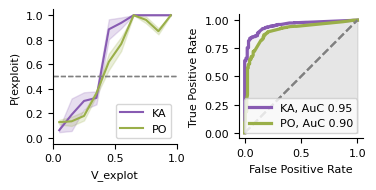

In [13]:
# Foraging value predicts switching
fig, axs = plot_value_vs_shift(behav, xlabel='V_explot', ylabel='P(exploit)')
plt.show()

Model 2 Macro-Averaged AUC (3-way choice): 0.930
Model 2 Accuracy (3-way choice): 0.824
Model 2 Macro-Averaged AUC (3-way choice): 0.884
Model 2 Accuracy (3-way choice): 0.714


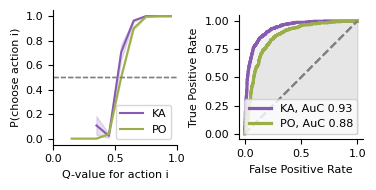

In [14]:
# Now when the warning occurs, it will raise an exception and stop execution
fig, ax = plot_q_vals_vs_decision(behav, xlabel='Q-value for action i', ylabel='P(choose action i)')
plt.show()
